# Computing Lifetimes of Spiral Tips
Tim Tyree<br>
6.29.2020<br>

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show


import numba, trackpy
# from numba import njit, jit, vectorize
# from PIL import Image
# import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#load the libraries
from lib import *
from lib.dist_func import *
# from lib.operari import *
# from lib.ProgressBar import *
# from lib.minimal_model import *
# from lib.TexturePlot import *
# from lib.get_tips import *
# from lib.minimal_model import *
# from lib.intersection import *
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# post process log to get tip positions

In [27]:
#search for input_fn "tip_log_"+ .. .._ +num+".csv"
input_fn = search_for_file(nb_dir+'/Data/ds_5_param_set_8')
print(input_fn)
#TODO: find a proper way to terminate the Tk application launched by search_for_file.  it doesn't terminate

File: /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_002.csv.
/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_002.csv.


In [32]:
print("have you the right sigma and threshold?")
ds = 5; sigma = .5; threshold = 0.9

# input_fn = 'Log/tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv'
os.chdir(nb_dir+'/Data/ds_5_param_set_8')
str(os.path.exists(input_fn))+" it is that file exists,"

have you the right sigma and threshold?


'True it is that file exists.'

In [41]:
#save the tip positions expanded into rows
df_output = process_tip_log_file(input_fn)
saveherein = input_fn.replace('.csv','_processed.csv')
df_output.to_csv(saveherein, index=False)
beep(1)
print(f"and the resulting \"_processed.csv\" was supplanted herein:\n\t{saveherein}")

and the resulting "_processed.csv" was supplanted herein:
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_002_processed.csv.


In [136]:
#BLUF load processed df with tips as rows
df = pd.read_csv(input_fn)
fn = input_fn.split('/')[-1]
descrip = fn[:fn.find('_processed.csv')]
threshold = eval(fn[fn.find('threshold_')+len('threshold_'):].split('_')[0])
ds = eval(fn[fn.find('ds_')+len('ds_'):].split('_')[0])
sigma = eval(fn[fn.find('sigma_')+len('sigma_'):].split('_')[0])

# import tip positions

In [42]:
#if using ^that result of tip positions expanded into rows?
data_dir = saveherein
sigma = 1.0  #1.5#1.5#1.#1
threshold = 0.6#0.6  #0.9#0.95
V_threshold = 0.5
ext = ''#'001_'
# search_for_file()
# data_dir    = f'{nb_dir}/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}_{ext}processed.csv'

# 'Log/tip_log_ds_5_sigma_1.0_threshold_0.6_001_processed.csv'
# data_dir    = f'{nb_dir}/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}_processed.csv'
print(f"loading .csv of size {sys.getsizeof(data_dir)/10**3} KB from \n\t{data_dir}")
df = pd.read_csv(data_dir)

save_folder = '/'+os.path.join(*data_dir.split('/')[:-2])+'/trajectories/'
os.chdir(save_folder)
print(f"files will be saved in the folder: \n\t{save_folder}")

loading .csv of size 0.182 KB from 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_002_processed.csv.
files will be saved in the folder: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/


In [48]:
# test data has no odd spiral tips since the data has periodic boundary conditions
assert not (np.array(list(set(df.n.values)))%2==1).any()
print('no odd spiral tips exist.')

no odd spiral tips exist.


#### DONE: get trackpy to use periodic boundary distances
- failing ^that make trackpy use my distance function

__Trackpy warns in its more seriptitious print statements that user defined distances are not tested__<br>
Thus, I must test my own use case on a test with a known response.

__How trackpy handles user defined distance functions__
The only appearance of dist_func in trackpy's source code from github is in subnet.py.  In which, trackpy.subnet.HashBTree.rebuild passes dist_func to sklearn as follows <br>
`sklearn.neighbors.BallTree(coords_mapped,metric='pyfunc', func=self.dist_func`

`sklearn.neighbors.BallTree` has func as an additional kwarg, which is passed to the distance metric class, DistanceMetric.  In the docstring of that function, I find the specification for `DistanceMetric`.

__Bottom Line Up Front (BLUF) the function must take two 1D numpy arrays and return a distance.  Everything will be slower because of the overhead of calling python functions__

In [87]:
# from sklearn.neighbors import BallTree, DistanceMetric

In [194]:
print('''**User-defined distance:**

===========    ===============    =======
identifier     class name         args
-----------    ---------------    -------
"pyfunc"       PyFuncDistance     func
===========    ===============    =======

Here ``func`` is a function which takes two one-dimensional numpy
arrays, and returns a distance.  Note that in order to be used within
the BallTree, the distance must be a true metric:
i.e. it must satisfy the following properties

1) Non-negativity: d(x, y) >= 0
2) Identity: d(x, y) = 0 if and only if x == y
3) Symmetry: d(x, y) = d(y, x)
4) Triangle Inequality: d(x, y) + d(y, z) >= d(x, z)

Because of the Python object overhead involved in calling the python
function, this will be fairly slow, but it will have the same
scaling as other distances.''')

**User-defined distance:**

===========    ===============    =======
identifier     class name         args
-----------    ---------------    -------
"pyfunc"       PyFuncDistance     func
===========    ===============    =======

Here ``func`` is a function which takes two one-dimensional numpy
arrays, and returns a distance.  Note that in order to be used within
the BallTree, the distance must be a true metric:
i.e. it must satisfy the following properties

1) Non-negativity: d(x, y) >= 0
2) Identity: d(x, y) = 0 if and only if x == y
3) Symmetry: d(x, y) = d(y, x)
4) Triangle Inequality: d(x, y) + d(y, z) >= d(x, z)

Because of the Python object overhead involved in calling the python
function, this will be fairly slow, but it will have the same
scaling as other distances.


In [156]:
# this section was sent to lib.dist_func
# def get_distance_L2_pbc(width=200,height=200):
#     '''returns a function for the euclidean (L2) distance measure for a 2D rectangle with periodic boundary conditions.
#     width, height are the shape of that 2D rectangle.'''
#     @jit('f8(f8[:],f8[:])', nopython=True)
#     def distance_L2_pbc(point_1, point_2):
#         '''assumes getting shortest distance between two points with periodic boundary conditions in 2D.'''
#         mesh_shape=np.array((width,height))
#         dq2 = 0.
#         #     for q1, q2, width in zip(point_1[:2], point_2[:2], mesh_shape):
#         for q1, q2, wid in zip(point_1, point_2, mesh_shape):
#             dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#         return np.sqrt(dq2)
#     return distance_L2_pbc

# def test_get_distance_L2_pbc():
#     import trackpy, pandas as pd

#     #testing the pbc distance function
#     distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
#     assert(np.isclose(distance_L2_pbc(np.array([1.,1.]),np.array([1.,1.])),0.))
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([1.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,1.]))<3.)

#     #testing distance_L2_pbc in trackpy.link_df
#     df_test = pd.DataFrame({'frame':[1,2,2],'x':[1,100,199],'y':[1,100,199]})

#     # test that the default distance function maps 1,1 to 100,100 instead of 199,199
#     traj_test = trackpy.link_df(df_test, search_range=210)
#     assert((traj_test['particle'].values == np.array([0, 0, 1])).all())

#     # test that the pbc distance function maps 1,1 to 199,199 instead of 100,100
#     traj_test = trackpy.link_df(df_test, search_range=210, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())

#     # test that the pbc distance function can see accross boundarys when search_range is small
#     traj_test = trackpy.link_df(df_test, search_range=110, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())
#     return True

# track tips using periodic boundary conditions

In [134]:
# df_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_processed.csv'

df_dir = data_dir
data_dir

'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_0.5_threshold_0.9_002_processed.csv.'

In [153]:
df = pd.read_csv(df_dir)
h = 0.007
mem = 2
sr  = 1
distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'dist_func'         : distance_L2_pbc,
    'memory': mem}
df['frame'] = np.around(df['t']/h)
df = df.astype(dtype={'frame':int}).copy()
traj = trackpy.link_df(
    f=df,search_range=sr,t_column='frame', **link_kwargs)

beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

Frame 1328: 10 trajectories present.


KeyboardInterrupt: 

In [114]:
save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv')
traj.to_csv(save_fn, index=False)
print (save_fn)

tip_log_ds_5_sigma_0.5_threshold_0.9_002_traj_sr_1_mem_2.csv.


Now compute life times

# compute life times

particles still not being tracked right.  debug between two  time steps from the middle frames ah, search_range must be at least ~1e-2.  Using 1e-0 should work

In [24]:
save_fn = nb_dir+'/Data/ds_5_param_set_8/trajectories/tip_trajectories_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv'
h = 0.007
# data_fn = 'tip_log_ds_5_sigma_1.0_threshold_0.6_traj_sr_1.csv'
df_traj = pd.read_csv(save_fn)
print(save_fn)
descrip = 'forFig1'

/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/tip_trajectories_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv


In [14]:
df_traj.describe()

,n,t,x,y,frame,particle
count,287196.000000,287196.000000,287196.000000,287196.000000,287196.000000,287196.000000
mean,4.923300,214.842319,100.782009,108.457516,30691.759809,82.600684
std,2.836655,165.415956,54.610485,62.607048,23630.850823,40.401825
min,2.000000,0.007000,0.000099,0.002007,1.000000,0.000000
25%,2.000000,69.314000,57.420195,39.267808,9902.000000,54.000000
50%,4.000000,160.828500,101.976808,126.378819,22975.500000,102.000000
75%,6.000000,361.039000,146.357056,156.502630,51577.000000,109.000000
max,20.000000,557.508000,199.999999,199.993345,79644.000000,211.000000


In [15]:
#compute lifetimes
g = df_traj.groupby('particle')['t']
mx = g.agg(np.max)
mn = g.agg(np.min)
gd_lifetimes = mx - mn

# plot lifetimes

In [16]:
# ll=np.max(gd_lifetimes[gd_lifetimes>0.])
# print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")

 based on Wouter's results, we would expect a lifetime on the order of 10 ms from a birth/death rate of ~0.1/ms.  We have 557 ms of data, so we would expect on the order of 2*557*0.1=111 birth/death events.
 
 So, we expect at least one tip that lasts __10 ms__.

In [17]:
# plt.hist?

In [18]:
# plt.hist(out[out>-100], bins=30, density=True)

the longest living tip lasted 67315 time steps, which was 471.205 ms.
/Users/timothytyree/Documents/GitHub/care/notebooks/Figures/zero_odd_births-deaths_forFig1.png


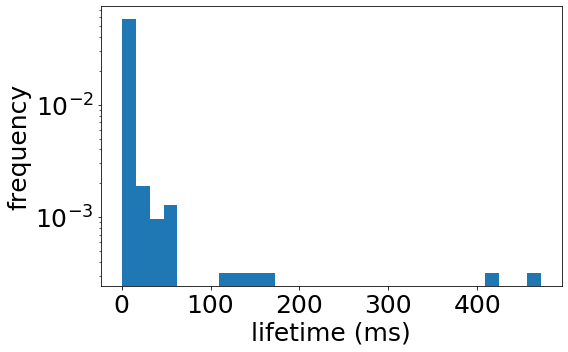

In [28]:
ll=np.max(gd_lifetimes[gd_lifetimes>0.])
print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
fig_fn = save_fn.replace('.csv','.png').replace('tip_log','hist_lifetimes')
# out = np.log(gd_lifetimes)

fontsize= 25

fig, ax = plt.subplots(figsize=(8,5))
plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
plt.ylabel('frequency', fontsize=fontsize)
plt.xlabel('lifetime (ms)', fontsize=fontsize)
ax.tick_params(axis='both', labelsize= fontsize)
plt.tight_layout()
# plt.show()
savefig_dir = f"{nb_dir}/Figures/zero_odd_births-deaths_{descrip}.png"
fig.savefig(savefig_dir,dpi=400)
print (savefig_dir)
# plt.savefig(fig_fn, dpi=300)

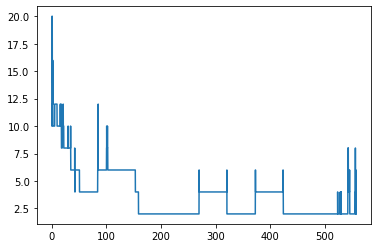

In [128]:
y_values = df_traj.n.values
x_values = df_traj.t.values
plt.plot(x_values,y_values)

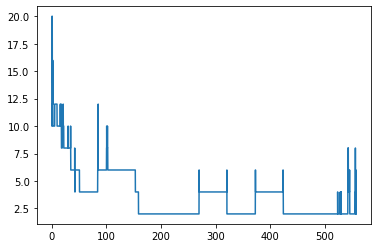

In [129]:
y_values = df_traj.n.values
x_values = df_traj.t.values
plt.plot(x_values,y_values)

In [127]:
# # (equivalently if pid's are not reused) take max and min time for each trajectory
# def get_lifetime(trajectory_list):
#     '''trajectory_list is a list of lists.  
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )'''
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )
# #    TODO: for a given .csv of tip positions, make their trajectories naively in trackpy


# DONE: walk through the log folder converting tip positions to tip trajectories

In [154]:
log_dir = f"{nb_dir}/Data/ds_5_param_set_8/Log"
out_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
os.chdir(log_dir)
input_fn = 'tip_log_ds_5_sigma_0.5_threshold_0.9_002_traj_sr_1_mem_2.csv'
h = 0.007
sr  = 1
def get_df_and_kwargs(input_fn, width=200,height=200, mem = 2):
    df = pd.read_csv(input_fn)
    distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
    df['frame'] = np.around(df['t']/h)
    df = df.astype(dtype={'frame':int}).copy()
    link_kwargs = {
        'neighbor_strategy' : 'BTree',
        'dist_func'         : distance_L2_pbc,
        'memory': mem}
    return df, link_kwargs

In [155]:
#compute all _processed.csv tip logs in the Log folder
os.chdir(log_dir)
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(log_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find('_processed.csv') !=-1:
            print(f"starting on {df_dir}...")
            df, link_kwargs = get_df_and_kwargs(input_fn=df_dir, width=200,height=200, mem = 2)
            # test whether data has no odd spiral tips since the data has periodic boundary conditions
            if (np.array(list(set(df.n.values)))%2==1).any():
                print(f'WARNING: an odd spiral tips exists in \n\t{fn}')
            
            # compute trajectories (slowest part)
            traj = trackpy.link_df(f=df,search_range=sr,t_column='frame', **link_kwargs)
            
            #save results
            os.chdir(out_dir)
            save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv').replace('tip_log','tip_trajectories')
            traj.to_csv(save_fn, index=False)

Frame 863: 10 trajectories present.


KeyboardInterrupt: 

In [148]:
beep(7)

0

# make a histogram for each output 

In [6]:
sr  = 1
mem = 2
dpi = 300
h = 0.007
traj_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
save_dir = f"{nb_dir}/Figures"
os.chdir(traj_dir)
fontsize=15

In [11]:
#compute all _processed.csv tip logs in the Log folder
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(traj_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find(f'_traj_sr_{sr}_mem_{mem}.csv') !=-1:
            print(f"starting on {df_dir}...")
            df_traj = pd.read_csv(df_dir)

#             df = pd.read_csv(data_dir)

            # compute lifetimes
            g = df_traj.groupby('particle')['t']
            mx = g.agg(np.max)
            mn = g.agg(np.min)
            gd_lifetimes = mx - mn
#             gd_lifetimes = gd['max']- gd['min']
            
            #plot results
            ll=np.max(gd_lifetimes[gd_lifetimes>0.])
            print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
            fig_fn = df_dir.replace('.csv','.png').replace('_traj_','hist_lifetimes')
            # out = np.log(gd_lifetimes)
            plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
            plt.ylabel('frequency', fontsize=fontsize)
            plt.xlabel('lifetime (ms)', fontsize=fontsize)
            # plt.show()
           
            
            #save results
            os.chdir(save_dir)
            save_fn = os.path.basename(df_dir).replace(f'_traj_sr_{sr}_mem_{mem}.csv', f'_sr_{sr}_mem_{mem}.csv').replace('tip_trajectories','histogram_lifetimes')
            plt.savefig(fig_fn, dpi=dpi)
            plt.close()

starting on ./tip_log_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 137 time steps, which was 0.959 ms.
starting on ./tip_trajectories_ds_5_6.23-2_traj_sr_1_mem_2.csv...
the longest living tip lasted 56127 time steps, which was 392.889 ms.
starting on ./tip_trajectories_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 67315 time steps, which was 471.205 ms.
starting on ./tip_trajectories_ds_5_sigma_1.0_threshold_0.6_001_traj_sr_1_mem_2.csv...
the longest living tip lasted 56127 time steps, which was 392.889 ms.
starting on ./tip_trajectories_ds_5_sigma_0.5_threshold_0.9_002_traj_sr_1_mem_2.csv...
the longest living tip lasted 28675 time steps, which was 200.725 ms.
starting on ./tip_trajectories_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv...
the longest living tip lasted 67211 time steps, which was 470.477 ms.
starting on ./tip_log_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv...
the longest living tip lasted 

# TODO: take a close look at when those n = 6 numbers flicker to n=12 during trackpy.link_df
### __answer__ frame was rounding funny like in fortran
also, my data has some frames missing, and I don't know why...<br>
TODO: see if frames are still missing when `recording` is not recomputed every timestep

In [91]:
retval = traj.groupby('frame')['particle', 'n', 't']

In [92]:
l = 69990
frame_indices = retval.count().loc[l-1:l+2].index
# .reduce('add')

In [95]:
for fi in frame_indices:
    pass
#     print(df.loc[fi])


In [101]:
l = 69990

df.loc[(df.frame >= l-2) & (df.frame <= l+2)]#[['particle', 'n', 't']]

,n,s1,s2,t,x,y,frame
268336,2,"(0,)","(2,)",489.916,137.998865,134.332334,69988
268337,2,"(0,)","(2,)",489.916,90.176812,178.142970,69988
268338,2,"(0,)","(2,)",489.923,137.998870,134.332656,69989
268339,2,"(0,)","(2,)",489.923,90.176902,178.143010,69989
268340,2,"(0,)","(2,)",489.930,137.998875,134.332975,69990
268341,2,"(0,)","(2,)",489.930,90.176990,178.143049,69990
268342,2,"(0,)","(2,)",489.937,137.998881,134.333293,69990
268343,2,"(0,)","(2,)",489.937,90.177078,178.143087,69990
268344,2,"(0,)","(2,)",489.944,137.998886,134.333608,69992
268345,2,"(0,)","(2,)",489.944,90.177164,178.143125,69992


In [102]:
# frame_indices = retval.count().loc[l-1:l+2].index

In [103]:
traj.loc[(traj.frame >= l-2) & (traj.frame <= l+2)]

,n,s1,s2,t,x,y,frame,particle
268337,2,"(0,)","(2,)",489.916,90.176812,178.142970,69988,27708
268336,2,"(0,)","(2,)",489.916,137.998865,134.332334,69988,27707
268338,2,"(0,)","(2,)",489.923,137.998870,134.332656,69989,27707
268339,2,"(0,)","(2,)",489.923,90.176902,178.143010,69989,27708
268340,2,"(0,)","(2,)",489.930,137.998875,134.332975,69990,27707
268341,2,"(0,)","(2,)",489.930,90.176990,178.143049,69990,27708
268342,2,"(0,)","(2,)",489.937,137.998881,134.333293,69990,27709
268343,2,"(0,)","(2,)",489.937,90.177078,178.143087,69990,27710
268345,2,"(0,)","(2,)",489.944,90.177164,178.143125,69992,27710
268344,2,"(0,)","(2,)",489.944,137.998886,134.333608,69992,27709


How am I computing the field "frame"? How is it rounding?

In [111]:
df['frame'] = np.around(df['t']/h)
df = df.astype(dtype={'frame':int}).copy()

In [112]:
df = traj.copy()
df['frame'] = np.around(df['t']/h)
df = df.astype(dtype={'frame':int}).copy()
df.loc[(traj.frame >= l-2) & (traj.frame <= l+2)]

,n,s1,s2,t,x,y,frame,particle
268337,2,"(0,)","(2,)",489.916,90.176812,178.142970,69988,27708
268336,2,"(0,)","(2,)",489.916,137.998865,134.332334,69988,27707
268338,2,"(0,)","(2,)",489.923,137.998870,134.332656,69989,27707
268339,2,"(0,)","(2,)",489.923,90.176902,178.143010,69989,27708
268340,2,"(0,)","(2,)",489.930,137.998875,134.332975,69990,27707
268341,2,"(0,)","(2,)",489.930,90.176990,178.143049,69990,27708
268342,2,"(0,)","(2,)",489.937,137.998881,134.333293,69991,27709
268343,2,"(0,)","(2,)",489.937,90.177078,178.143087,69991,27710
268345,2,"(0,)","(2,)",489.944,90.177164,178.143125,69992,27710
268344,2,"(0,)","(2,)",489.944,137.998886,134.333608,69992,27709


# spiral tip investigating tips with small lifetimes
- TODO: plot tip number versus time for trajectories and raw positions
    - Does tip doubling still exist?
    - if so, consider investigating tip doubling near missing frames explicitely plug into trackpy.link_df


- TODO: select tips with short lifetimes. visualize.
- TODO: select tips with long lifetimes. visualize.

 - TODO(later): compute the velocity of a given tip that doesn't cross the periodic boundaries



# TODO: select the long life time spiral tips and plot their birth death rates

In [176]:
#import most recent tip trajectory data and the corresponding raw tips
data_dir_traj = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
data_fn_traj  = 'tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2.csv'

data_dir_log  = f"{nb_dir}/Data/ds_5_param_set_8/Log"
data_fn_log_processed = 'tip_log_ds_5_sigma_1.0_threshold_0.6_processed.csv'
# data_fn_log = 'tip_log_ds_5_sigma_1.0_threshold_0.6_001.csv' #not terribly useful

In [177]:
os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)
# select only data after 100 milliseconds
df = df[df.t>100].copy()

print('tip trajectories:')
df.head()

tip trajectories:


,n,s1,s2,t,x,y,frame,particle
95154,8,"(0, 0)","(0, 1)",100.002,61.171133,5.942526,14286,90
95155,8,"(0,)","(0,)",100.002,53.239457,34.585330,14286,34
95156,8,"(0,)","(0,)",100.002,23.123920,80.260837,14286,127
95157,8,"(0,)","(0,)",100.002,55.480390,123.545034,14286,2
95158,8,"(1,)","(0,)",100.002,142.687789,133.002978,14286,153


In [178]:
os.chdir(data_dir_log)
df_log = pd.read_csv(data_fn_log_processed)

# select only data after 100 milliseconds
df_log = df_log[df_log.t>100].copy()
print('tip log processed:')
df_log.head()

tip log processed:


,n,s1,s2,t,x,y
94748,6,"(0, 0)","(0, 1)",100.002,62.249218,5.993247
94749,6,"(0,)","(0,)",100.002,53.146188,35.853256
94750,6,"(0,)","(0,)",100.002,23.980952,79.164273
94751,6,"(0,)","(0,)",100.002,56.459704,123.055582
94752,6,"(1,)","(0,)",100.002,140.907813,134.583759


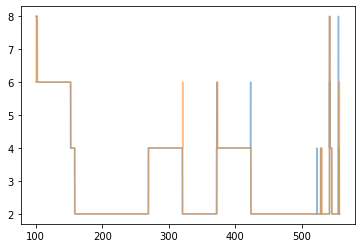

In [179]:
# plot tip number versus time for trajectories
t_values = df.t.values
n_values = df.n.values
plt.plot(t_values, n_values, alpha=0.5)

# plot tip number versus time raw positions
t_values = df_log.t.values
n_values = df_log.n.values
plt.plot(t_values, n_values, alpha=0.5)

In [180]:
df.describe()

,n,t,x,y,frame,particle
count,193288.000000,193288.000000,193288.000000,193288.000000,193288.000000,193288.000000
mean,3.636232,299.235453,105.359724,113.573918,42747.921858,155.676053
std,1.631444,135.700411,49.124917,60.964139,19385.773071,49.377444
min,2.000000,100.002000,0.111426,0.000117,14286.000000,2.000000
25%,2.000000,157.703000,69.369945,57.889172,22529.000000,153.000000
50%,4.000000,297.594500,108.997731,132.290340,42513.500000,165.000000
75%,4.000000,407.709750,148.172166,155.649721,58244.250000,178.000000
max,8.000000,556.290000,199.955035,199.999995,79470.000000,313.000000


# do spiral tips with a sufficiently large lifetime reproduce known results?

In [181]:
#TODO: test for gaps in a given trajectory
#TODO: test for consistency between frame and time

In [182]:
xmin=0; ymin=0; xmax=200; ymax=200; 
axis = [xmin,xmax,ymin,ymax]


In [183]:
#naive computation of lifetime for a given tip
pid = 10
def get_lifetime(pid,df):
    mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
    lifetime = mx-mn #seconds?
    return lifetime

In [184]:
pid_values = np.array(list(set(df.particle.values)))
# lifetime_values = [0.*pid for pid in pid_values]

lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])




In [186]:
# len(lifetime_values[boo])

In [133]:
# plt.hist(x)

In [158]:
#the above spiral tip lifetime estimates may not be accurate.  But W±1 = 0...
#TODO: plot the xy positions of the long lived spiral tips, coloring by pid.


'tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2.csv'

saved figure in 
	tip_trajectories_ds_5_sigma_1.0_threshold_0.9_traj_sr_1_mem_2_lifetimes_longerthan_14.00.png.


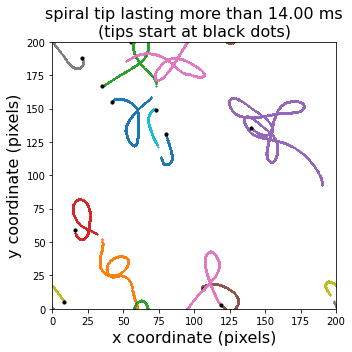

In [270]:
#plot the xy trajectory for longliving tips
saving = True
fig, ax = plt.subplots(figsize=(5, 5))
fontsize=16

LT_thresh = 14 #14 = 0.007*2000
boo = (lifetime_values>LT_thresh)
savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = data_fn.replace('.csv',f'_lifetimes_longerthan_{LT_thresh:.2f}.png')


for pid in pid_values[boo]:
    x_values ,y_values = df_traj[(df_traj.particle==pid) ][['x','y']].values.T
    plt.scatter(x_values,y_values, s=.1)
    plt.scatter([x_values[0]],[y_values[0]], s=10,color='black')
plt.axis(axis)
plt.title(f'''spiral tip lasting more than {LT_thresh:.2f} ms
(tips start at black dots)''', fontsize=fontsize)
ax.set_xlabel('x coordinate (pixels)', fontsize=fontsize)
ax.set_ylabel('y coordinate (pixels)', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

__Long Lifetimes at later times look reasonable__<br>
for ^these lifetimes, the spatial trajectories appear robust when considering only lifetimes 1.5ms or longer, but not for 1.0ms or shorter.  Many of the spiral tips with high frequencies are removed by ommiting data shortly after initialization (considering only times greater than t=100ms).

### testing for sensitivity to LT_thresh
The total number of spiral tips appears reletivley stable when considering only spiral tips with a lifetime greater than 2 milliseconds.

In [241]:
x_values = np.linspace(1,15,100)
y_values = []
for LT_thresh in x_values:
    boo = (lifetime_values>LT_thresh)
    number_of_particles = lifetime_values[boo].shape[0]
    y_values.append(number_of_particles)
y_values = np.array(y_values)

saved figure in 
	total_num_tips_versus_minimum_lifetime_threshold_zoomed.png.


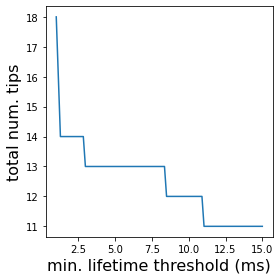

In [242]:
#plot total particle number versus LT_thresh.  
#plot the xy trajectory for longliving tips
saving = True
savefig_fn = 'total_num_tips_versus_minimum_lifetime_threshold_zoomed.png'
fig, ax = plt.subplots(figsize=(4, 4))
fontsize=16

ax.plot(x_values,y_values)
# ax.set_title('total number of spiral tips observed after time t=100ms', fontsize=fontsize)
ax.set_xlabel('min. lifetime threshold (ms)', fontsize=fontsize)
ax.set_ylabel('total num. tips', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [256]:

# #TODO: plot a better histogram of tips lifetimes
# boo = (lifetime_values>0.007*2000)
# mu = 200
# sigma = 25
# n_bins = 50
# x = lifetime_values[boo]

# fig, ax = plt.subplots(figsize=(8, 4))

# # plot the cumulative histogram
# n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')

# # Add a line showing the expected distribution.
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# y = y.cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# # Overlay a reversed cumulative histogram.
# ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
#         label='Reversed emp.')

# # tidy up the figure
# ax.grid(True)
# ax.legend(loc='right')
# ax.set_title('Cumulative step histograms')
# ax.set_xlabel('spiral tip lifetime (sec)')
# ax.set_ylabel('Likelihood of occurrence')


# plot a histogram of spiral tip lifetimes when considering only these features

Despite this lifetime spiral tips still exist.  Since the xy-plots of the trajectories look reasonable, it is worth considering what may distinguish these spiral tips.  
- TODO: plot birth death rates of spiral tips when only considering these tips

- TODO: plot local EP properties for short-lived and long-lived spiral tips

(array([3., 0., 1., 7., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  2.891     ,  17.95686667,  33.02273333,  48.0886    ,
         63.15446667,  78.22033333,  93.2862    , 108.35206667,
        123.41793333, 138.4838    , 153.54966667, 168.61553333,
        183.6814    , 198.74726667, 213.81313333, 228.879     ,
        243.94486667, 259.01073333, 274.0766    , 289.14246667,
        304.20833333, 319.2742    , 334.34006667, 349.40593333,
        364.4718    , 379.53766667, 394.60353333, 409.6694    ,
        424.73526667, 439.80113333, 454.867     ]),
 <BarContainer object of 30 artists>)

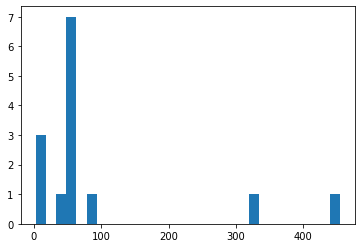

In [246]:
LT_thresh = 2
boo = (lifetime_values>LT_thresh)
x = lifetime_values[boo]
plt.hist(x, bins=30)


saved figure in 
	spiral_tip_histogram.png.


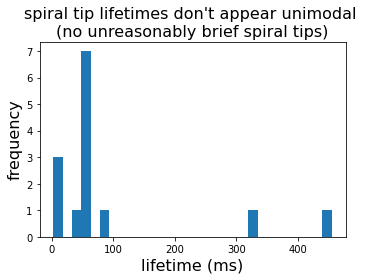

In [277]:
#plot the xy trajectory for longliving tips
saving = True
fig, ax = plt.subplots(figsize=(5, 4))
fontsize=16


savefig_dir = f'{nb_dir}/Figures/lifetime_analysis'
savefig_fn = 'spiral_tip_histogram.png'

for pid in pid_values[boo]:
    ax.hist(x, bins = 30)#, color='b')
# plt.axis(axis)
ax.set_title(f'''spiral tip lifetimes don't appear unimodal \n(no unreasonably brief spiral tips)''', fontsize=fontsize)
ax.set_xlabel('lifetime (ms)', fontsize=fontsize)
ax.set_ylabel('frequency', fontsize=fontsize)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [253]:
xcoord_mesh, ycoord_mesh = np.meshgrid(np.arange(0,200),np.arange(0,200))

In [254]:
df.particle==5

95154     False
95155     False
95156     False
95157     False
95158     False
          ...  
288437    False
288438    False
288439    False
288440    False
288441    False
Name: particle, Length: 193288, dtype: bool